In [134]:
from __future__ import print_function
import numpy as np
import dicom
import matplotlib.pyplot as plt
import os, glob
import tensorflow as tf
import tflearn
import sklearn
from numpy import interp
from sklearn.metrics import roc_curve, roc_auc_score
import scipy
import datetime
%matplotlib inline

# Import and preprocess data

In [169]:
def importHeartData(calmFile, stressFile, ind, resize):
    """
    Import heart data and extract the pixel array.
    Slice halfway along ind axis.
    Concatenate and return stress file and calm file.
    If resize == 1, interpolate data to fit (34,34) arr.
    """
    calmTmp = dicom.read_file(calmFile).pixel_array
    stressTmp = dicom.read_file(stressFile).pixel_array
    
    calmTmp = cropHeart(calmTmp)
    stressTmp = cropHeart(stressTmp)
    
    # Slice halfway along ind axis
    if ind==0:
        calm2d = calmTmp[calmTmp.shape[ind]/2]
        stress2d = stressTmp[stressTmp.shape[ind]/2]
    if ind==1:
        calm2d = calmTmp[:,calmTmp.shape[ind]/2]
        stress2d = stressTmp[:,stressTmp.shape[ind]/2]
    if ind==2:
        calm2d = calmTmp[:,:,calmTmp.shape[ind]/2]
        stress2d = stressTmp[:,:,stressTmp.shape[ind]/2]

           
    # Pad the 2d slices with zeros so that they are all the same size
    zeroArr0 = np.zeros((34,34))
    zeroArr1 = np.zeros((34,34))
    
    if resize == 1:      
        # Resize the 2D slices
        calmRatio = 34.0/np.amax(calm2d.shape)
        stressRatio = 34.0/np.amax(stress2d.shape)

        calm2d = scipy.ndimage.interpolation.zoom(calm2d, (calmRatio))
        stress2d = scipy.ndimage.interpolation.zoom(stress2d, (stressRatio))

        if calm2d.shape[0] != 34:
            startInd = (34 - calm2d.shape[0])/2
            zeroArr0[startInd:calm2d.shape[0]+startInd,:calm2d.shape[1]] = calm2d
        if calm2d.shape[1] != 34:
            startInd = (34 - calm2d.shape[1])/2
            zeroArr0[:calm2d.shape[0],startInd:calm2d.shape[1]+startInd] = calm2d

        if stress2d.shape[0] != 34:
            startInd = (34 - stress2d.shape[0])/2
            zeroArr1[startInd:stress2d.shape[0]+startInd,:stress2d.shape[1]] = stress2d
        if stress2d.shape[1] != 34:
            startInd = (34 - stress2d.shape[1])/2
            zeroArr1[:stress2d.shape[0],startInd:stress2d.shape[1]+startInd] = stress2d
    
    else:
        zeroArr0[:calm2d.shape[0],:calm2d.shape[1]] = calm2d
        zeroArr1[:stress2d.shape[0],:stress2d.shape[1]] = stress2d
      
    zeroArr0 = sklearn.preprocessing.normalize(zeroArr0)
    zeroArr1 = sklearn.preprocessing.normalize(zeroArr1)

    catOut = [zeroArr0, zeroArr1]
    return catOut

def importDir(parentDir):
    """
    Scan though directories in parent directory; look for dirs labelled 
    STRESS* or REST* in the imediate subdirs and import any dcm files in them.
    Return a dataFile of the concatenated stress and calm *.dcm files.
    """
    tmplst = []
    for dirs in os.listdir(parentDir):
        cwdStress = glob.glob(parentDir+"/"+dirs+"/STRESS*/*.dcm")
        cwdCalm = glob.glob(parentDir+"/"+dirs+"/REST*/*.dcm")
        # Get slices halfway along x axis:
        xAx = importHeartData(cwdCalm[0], cwdStress[0], 0, 1) # zAx, and zoom
        tmplst.append(xAx)
        
    dataFile = np.array(tmplst)
    #print(dataFile.shape)
    
    return dataFile

def cropHeart(inp):
    """
    Crop the heart so that all the padding is done away with.
    Output cropped heart.
    """
    # argwhere will give you the coordinates of every point above smallest
    true_points = np.argwhere(inp)
    # take the smallest points and use them as the top left of your crop
    top_left = true_points.min(axis=0)
    # take the largest points and use them as the bottom right of your crop
    bottom_right = true_points.max(axis=0)
    out = inp[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
          top_left[1]:bottom_right[1]+1,   # inclusive
          top_left[2]:bottom_right[2]+1]  
    return out

In [170]:
# Do data import
normDir = "./data/nlst"
normDat = importDir(normDir)
abDir = "./data/rlst"
abDat = importDir(abDir)
inData = np.concatenate([normDat[:abDat.shape[0]], abDat]) # Normal and abnormal data same number of ppts

# Do labelling
normLab = np.zeros(normDat.shape[0])[:abDat.shape[0]]
abLab = np.ones(abDat.shape[0])
labels = np.concatenate([normLab, abLab])
    
# Mutual shuffle
shufData, shufLab = sklearn.utils.shuffle(inData, labels, random_state=1)
shufData = np.reshape(shufData,(-1,2,34,34,1))
shufLabOH = np.eye(2)[shufLab.astype(int)] # One hot encode

# k fold the data
k = 3
kfoldData = np.array_split(shufData, k)
kfoldLabelsOH = np.array_split(shufLabOH, k)
kfoldLabels = np.array_split(shufLab, k)
print(kfoldData[0].shape)

(20, 2, 34, 34, 1)


In [171]:
np.set_printoptions(threshold=np.inf) #threshold=1000 is default
kfoldData[0][0][0].reshape((34,34))

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
  

# Visualise input data

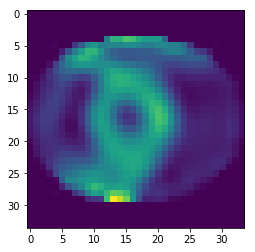

In [172]:
plt.imshow(shufData[30,0].reshape((-1,34)))

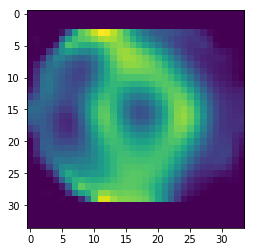

In [173]:
plt.imshow(shufData[30,1].reshape(-1,34))

# Neural net

In [82]:
spec = []
sens = []
roc = []

In [146]:
for i in np.arange(0,k,1):
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net = tflearn.layers.core.input_data(shape=[None, 2, 34, 34, 1])

    # First layer:
    net = tflearn.layers.conv.conv_3d(net, 16, [2,5,5],  activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_3d(net, [1,2,2], strides=[1,2,2])

    # Second layer:
    net = tflearn.layers.conv.conv_3d(net, 32, [2,5,5], activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_3d(net, [1,2,2], strides=[1,2,2])

    # Fully connected layers
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.01, activation="leaky_relu")
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)
    
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.01, activation="leaky_relu")
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)

    # Output layer:
    net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

    net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')
    model = tflearn.DNN(net, tensorboard_verbose=0)
    
    # Train the model, leaving out the kfold not being used
    dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 2, 34, 34, 1])
    dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
    model.fit(dummyData, dummyLabels, batch_size=10, n_epoch=50, show_metric=True)
    
    # Get sensitivity and specificity
    illTest = []
    healthTest = []
    for index, item in enumerate(kfoldLabels[i]):
        if item == 1:
            illTest.append(kfoldData[i][index])
        if item == 0:
            healthTest.append(kfoldData[i][index])

    healthLabel = np.tile([1,0], (len(healthTest), 1))
    illLabel = np.tile([0,1], (len(illTest), 1))
    sens.append(model.evaluate(np.array(healthTest), healthLabel))
    spec.append(model.evaluate(np.array(illTest), illLabel))

    # Get roc curve data
    predicted = np.array(model.predict(np.array(kfoldData[i])))
    fpr, tpr, th = roc_curve(kfoldLabels[i], predicted[:,1])
    auc = roc_auc_score(kfoldLabels[i], predicted[:,1])
    roc.append([fpr, tpr, auc])

Training Step: 199  | total loss: 0.48000 | time: 1.198s
| Adam | epoch: 050 | loss: 0.48000 - acc: 0.7973 -- iter: 30/39
Training Step: 200  | total loss: 0.49543 | time: 1.581s
| Adam | epoch: 050 | loss: 0.49543 - acc: 0.7731 -- iter: 39/39
--


# Postprocessing (specificity, sensitivity, roc curves)

In [147]:
aucs = []
for i in np.arange(k):
    aucs.append(roc[i][2])
    
print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens), "\nROC AUC:", aucs, "\nAvg:", np.mean(aucs[:][2]))

Specificity: [[0.0], [0.38461539149284363], [0.63636362552642822], [0.80000001192092896]] 
Avg: 0.455244757235 
Sensitivity: [[1.0], [0.71428573131561279], [0.375], [0.28571429848670959]] 
Avg: 0.593750007451 
ROC AUC: [0.52556818181818177, 0.63736263736263732, 0.53409090909090917] 
Avg: 0.534090909091


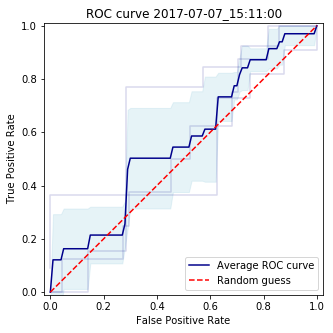

In [148]:
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

plt.figure(figsize=(5, 5))

tprs = []
base_fpr = np.linspace(0, 1, 101)

for i in np.arange(k):
    fpr = roc[i][0]
    tpr = roc[i][1]
    plt.plot(fpr, tpr, alpha=0.15, color="darkblue")
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, color="darkblue", label="Average ROC curve")
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--', label="Random guess")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve '+dt)
plt.legend(loc=4)
plt.axes().set_aspect('equal', 'datalim')
plt.savefig("./figures/rocCurves/"+dt+"-2dsliceCNN.png")